In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin
/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/README.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt


In [64]:
train=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")
train.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [68]:
print("Train data: ",train.shape)
print("Test data: ", test.shape)

Train data:  (1306122, 3)
Test data:  (375806, 2)


In [69]:
count=train['target'].value_counts()
count

0    1225312
1      80810
Name: target, dtype: int64

In [70]:
label=np.array(count.index)
value=np.array(count/(count.sum())*100)


In [71]:
value

array([93.81298225,  6.18701775])

In [72]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

In [73]:
import plotly.graph_objs as go


In [74]:
pie=go.Pie(labels=label,values=value)
layout=go.Layout(title="Imbalance distribution",
                font=dict(size=18),
                width=600,
                height=600)
data=pie
fig=go.Figure(data=data,layout=layout)
py.iplot(fig)

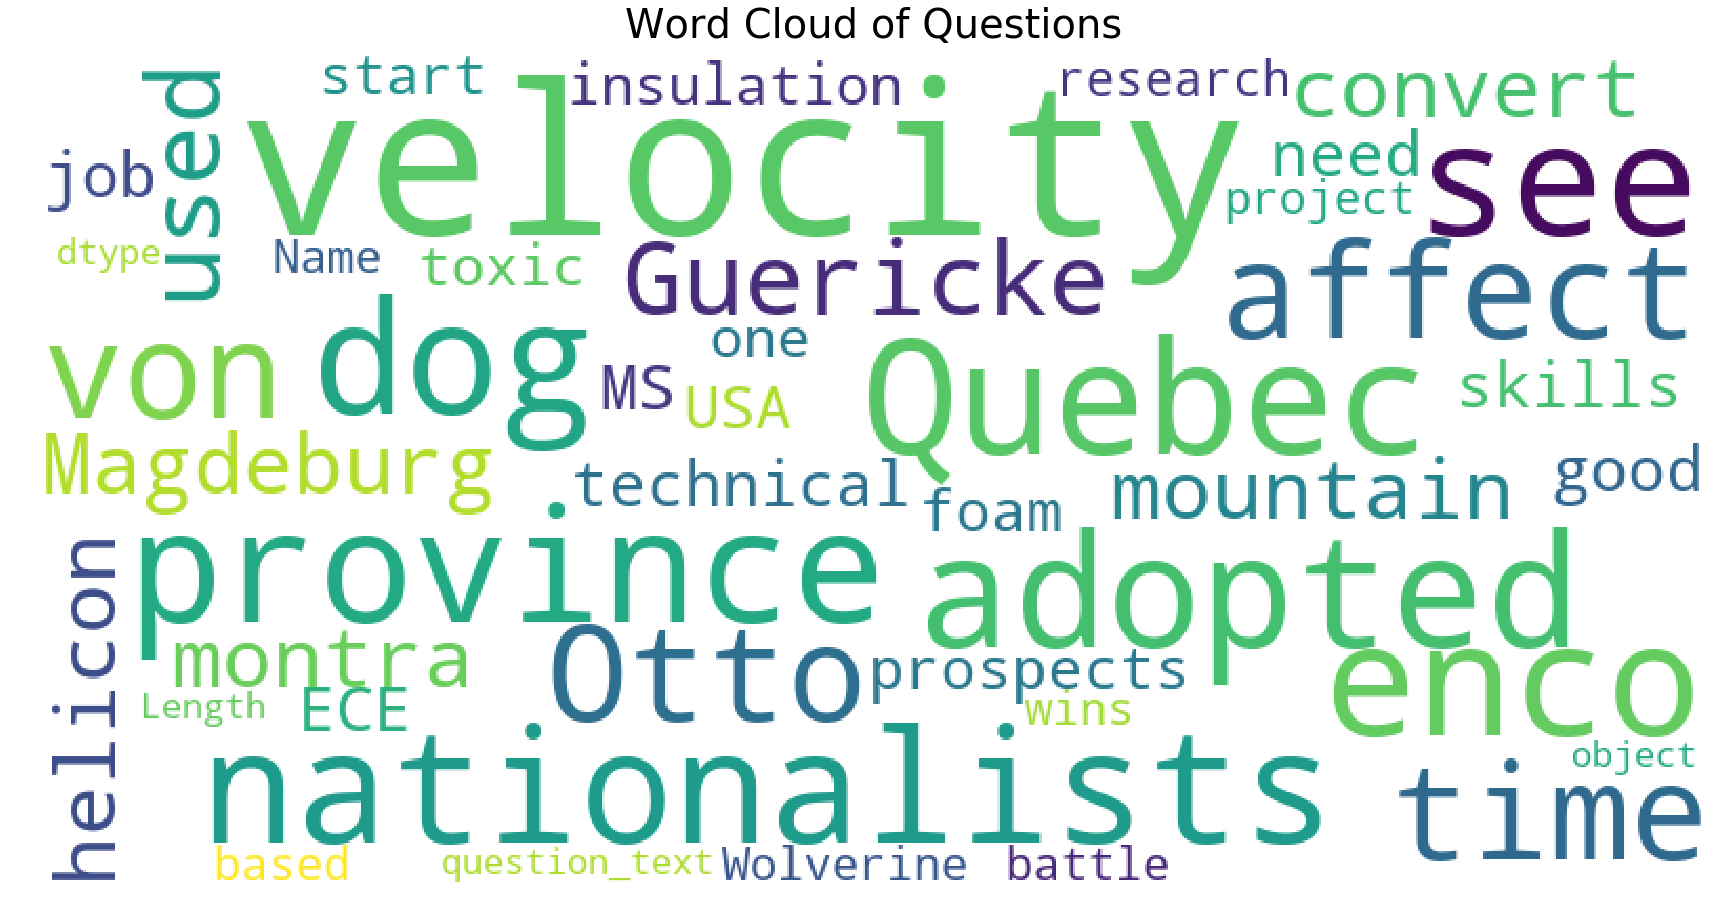

In [75]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
plot_wordcloud(train["question_text"], title="Word Cloud of Questions")

In [76]:
from collections import defaultdict
train_0=train[train["target"]==0]
train_1=train[train["target"]==1]


In [77]:
from collections import defaultdict
from nltk.corpus import stopwords
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

stop_words = set(stopwords.words('english')) 
insinc_df = train[train.target==1]
sinc_df = train[train.target==0]

def plot_ngrams(n_grams):

    ## custom function for ngram generation ##
    def generate_ngrams(text, n_gram=1):
        token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
        ngrams = zip(*[token[i:] for i in range(n_gram)])
        return [" ".join(ngram) for ngram in ngrams]

    ## custom function for horizontal bar chart ##
    def horizontal_bar_chart(df, color):
        trace = go.Bar(
            y=df["word"].values[::-1],
            x=df["wordcount"].values[::-1],
            showlegend=False,
            orientation = 'h',
            marker=dict(
                color=color,
            ),
        )
        return trace

    def get_bar(df, bar_color):
        freq_dict = defaultdict(int)
        for sent in df["question_text"]:
            for word in generate_ngrams(sent, n_grams):
                freq_dict[word] += 1
        fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
        fd_sorted.columns = ["word", "wordcount"]
        trace = horizontal_bar_chart(fd_sorted.head(13), bar_color)
        return trace    

    trace0 = get_bar(sinc_df, 'green')
    trace1 = get_bar(insinc_df, 'yellow')

    # Creating two subplots
    if n_grams == 1:
        wrd = "words"
    elif n_grams == 2:
        wrd = "bigrams"
    elif n_grams == 3:
        wrd = "trigrams"
    
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.03,
                              subplot_titles=["Frequent " + wrd + " of sincere questions", 
                                              "Frequent " + wrd + " of insincere questions"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    fig['layout'].update(height=500, width=750, paper_bgcolor='rgb(233,233,233)', title=wrd + " Count Plots")
    py.iplot(fig, filename='word-plots')

In [ ]:
plot_ngrams(1)

In [ ]:
plot_ngrams(2)

In [ ]:
plot_ngrams(3)

In [78]:
max_len=len(train["question_text"].max())
min_len=len(train["question_text"].min())

In [79]:
print('Maximum words in a question: ',max_len, 'words')
print('Minimum words in Question:  ',min_len, 'words')

Maximum words in a question:  238 words
Minimum words in Question:   44 words


In [80]:
#For better visualisation purpose need to delete/truncate some data 
train["num_words"]=train["question_text"].apply(lambda x:len(str(x).split()))
test["num_words"]=train["question_text"].apply(lambda x:len(str(x).split()))

In [81]:
import string
train["num_of_punctuation"]=train["question_text"].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))
test["num_of_punctuation"]=test["question_text"].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))

In [82]:
#Number of character in string
train["num_char"]=train["question_text"].apply(lambda x:len(str(x)))
test["num_char"]=test["question_text"].apply(lambda x: len(str(x)))

In [83]:
train["num_char"].loc[train["num_char"]>60]=60
train["num_words"].loc[train["num_words"]>350]=350
train["num_of_punctuation"].loc[train["num_of_punctuation"]>10]=10

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Number of words in each class')

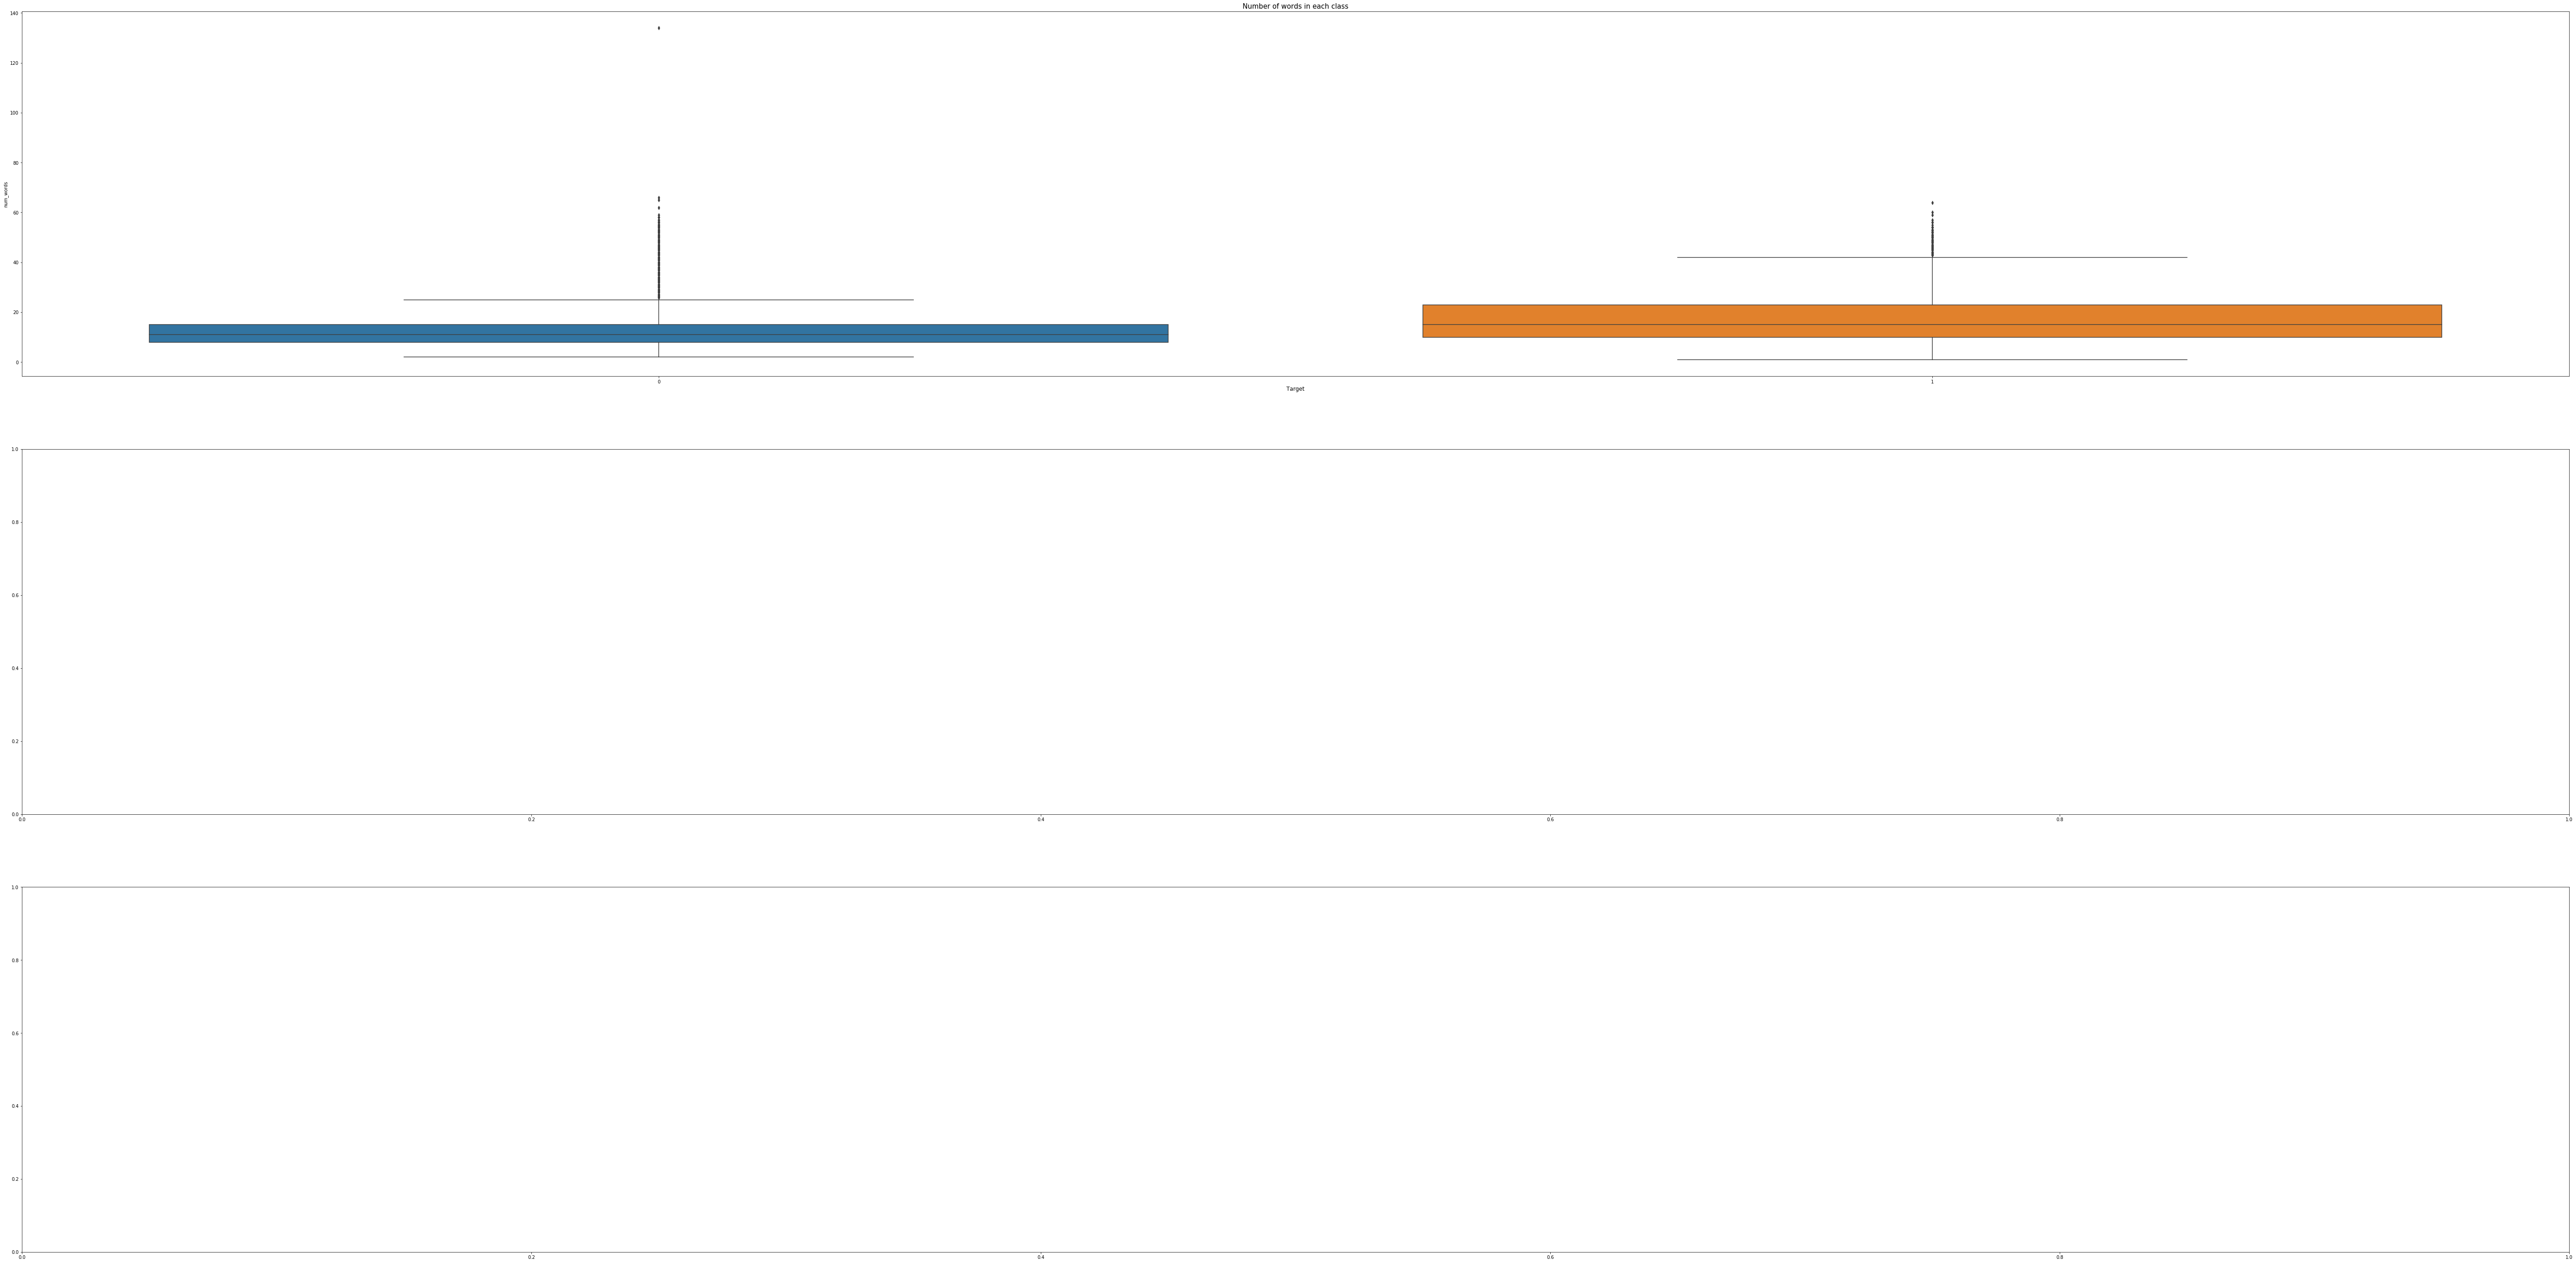

In [84]:
import seaborn as sns
color = sns.color_palette()
f, axes = plt.subplots(3, 1, figsize=(100,50))
sns.boxplot(x="target",y="num_words",data=train,ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

In [85]:
train["question_text"]=train["question_text"].str.lower()
test["question_text"]= test["question_text"].str.lower()

In [86]:
train.head(5)

,qid,question_text,target,num_words,num_of_punctuation,num_char
0,00002165364db923c7e6,how did quebec nationalists see their province...,0,13,1,60
1,000032939017120e6e44,"do you have an adopted dog, how would you enco...",0,16,2,60
2,0000412ca6e4628ce2cf,why does velocity affect time? does velocity a...,0,10,2,60
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0,9,1,57
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0,15,1,60


In [87]:
train['num_special_char'] = train['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
test['num_special_char'] = test['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

In [ ]:
train

In [132]:
qids = train.sort_values('num_special_char', ascending=False)['qid'].head(20).values
for id in qids:
  row = train[train['qid'].values == id]
  if row['target'].values[0] == 1: 
    color = '\033[31m'
  else:
    color = '\033[0m'


In [131]:
import re
def get_symbols_in_one(data):
    symbols=[]
    for text in data:
        s=re.findall(r'\W+',str(text))
        symbols.extend(s),
    return set(symbols)

In [90]:
final_symbols=get_symbols_in_one(train["question_text"].values)


In [130]:
def clean_tag(x):
    if '[math]' in x:
        x=re.sub('\[math\].*?math\]','MATH EQUATION',x)
    if 'http' in x or 'www' in x:
        x=re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x)
    return x

In [93]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

def clean_punct(x):
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, f' {punct} ')
  return x

In [94]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 
                'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 
                'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp',
                'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}
def correction_mispell(x):
    word=x.split()
    for i in range(0,len(word)):
        if mispell_dict.get(word[i]) is not None:
            word[i]=mispell_dict.get(word[i])
        elif mispell_dict.get(word[i].lower()) is not None:
            word[i]=mispell_dict.get(word[i].lower)
        word=" ".join(word)
        return word

In [95]:
#Remove stopwords
def stop_words_removal(x):
    x=[word for word in x.split() if word not in STOPWORDS ]
    x=' '.join(x)
    return x
            

In [ ]:
strr="Mathi this is the right time to shine"

In [ ]:
stop_words_removal(strr)
#print(strr.split())

In [125]:
contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", 
                       "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", 
                       "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", 
                       "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", 
                       "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", 
                       "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is",
                       "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam",
                       "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", 
                       "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", 
                       "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", 
                       "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", 
                       "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", 
                       "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", 
                       "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not",
                       "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not",
                       "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have",
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                       "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def clear_other_contradiction(x):
    special=["’", "‘", "´", "`"]
    for s in special:
        x=x.replace(s,"'")
    x = ' '.join([contraction_mapping[n] if n in contraction_mapping else n for n in x.split(" ")])
    return x


In [126]:
lemmatizer = WordNetLemmatizer()
def lemma_text(x):
  x = x.split()
  x = [lemmatizer.lemmatize(word) for word in x]
  x = ' '.join(x)

  return x

In [127]:
def data_cleaning(x):
    clean_tag(x)
    clean_punct(x)
    correction_mispell(x)
    stop_words_removal(x)
    clear_other_contradiction(x)
    lemma_text(x)
    return x
    
    
    

In [ ]:
train["Pre_Processed_question"]=train["question_text"].progress_map(lambda x:data_cleaning(x))
test["Pre_Processed_question"]=test["question_text"].progress_map(lambda x: data_cleaning(x))

In [ ]:
train